In [44]:
import pdfplumber
import pandas as pd
from nltk.tokenize import word_tokenize  # natural language processing 
from nltk.corpus import stopwords
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
from shiny import App, render, ui

pd.options.mode.chained_assignment = None  # default='warn'


# Question 1

In [2]:
# Doing the asgn intuitively
# # word_split = pdf_text.split()
# # idx_abstract = next((idx for idx, string in enumerate(word_split) if 'Abstract' in string), None)
# # ls_words = word_split[idx_abstract:]
# ls_words = [word.lower() for word in ls_words]

# english_stopwords = set(stopwords.words('english'))
# # english_stopwords

# filtered_words = [word for word in ls_words if word not in english_stopwords]
# filtered_words = [word for word in filtered_words if word not in ['–', 'e', '&', 'j', 'fr', 'et', '•', 'datascienceatthesingularity']]
# df_words = pd.DataFrame({'words': filtered_words})
# df_frequency = df_words['words'].value_counts().reset_index()
# df_frequency = df_frequency.sort_values(by='count', ascending=False)[0:20]

# dc_freq = dict(zip(df_frequency['words'], df_frequency['count']))
# dc_freq

# # word cloud theme
# wordcloud = WordCloud(width=800, height=400)
# # word cloud
# wordcloud.generate_from_frequencies(dc_freq)

# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.title('20 Most Common Words in Data Science at the Singularity by David Donoho')
# plt.show()

In [3]:
# 1.2 - Reading PDF document and separating lines by \n
def extract_text_from_pdf(pdf_path):
    text = ''
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text() + '\n'
    return text

pdf_text = extract_text_from_pdf("just_accepted_donoho.pdf")

In [4]:
# 1.3 Splitting lines by \n
pdf_text_split = pdf_text.split('\n')

In [5]:
# 1.4 Finding index where 'abstract' first appears and removing from list
idx_abstract = next((idx for idx, string in enumerate(pdf_text_split) if 'Abstract' in string), None)
pdf_text_split = pdf_text_split[9:]

In [6]:
# 1.5/1.6 Tokenizing each line and converting each word to a row
word_df = pd.DataFrame({'line': pdf_text_split})
word_df['word'] = word_df['line'].apply(word_tokenize)
word_df = word_df.explode('word')

# 1.7/1.8/1.9 Cleaning Data
word_df['word'] = word_df['word'].str.lower()
word_df.dropna(inplace=True)
english_stopwords = set(stopwords.words('english'))
word_df = word_df[~word_df['word'].isin(english_stopwords)]
word_df = word_df[~word_df['word'].isin(['j', 'fr-2', 'fr-3', 'e', 
                                         'fr-1', 'j.', 'fr', 'a.', 
                                         'datascienceatthesingularity'])]
word_df = word_df[word_df['word'].str.contains('[a-z]')]
# word_df

In [7]:
# 1.10 Term-Frequency Data Frame
term_freq_df = word_df['word'].value_counts().reset_index()

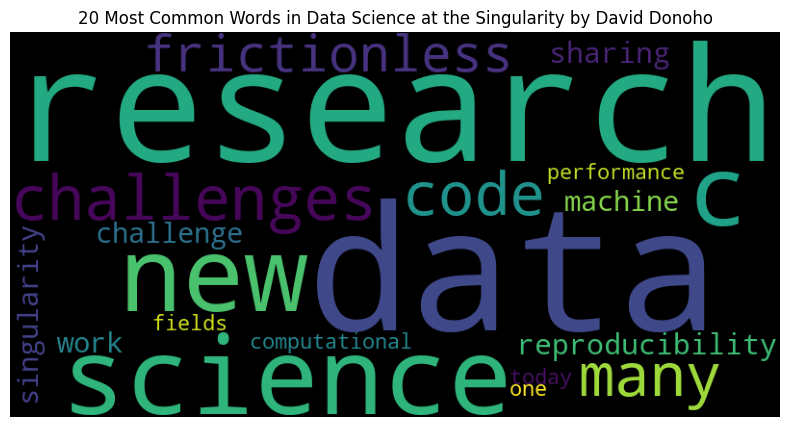

In [8]:
# 1.11 Producing word cloud for 20 most used words
term_freq_df = term_freq_df[0:20]
dc_word_freq = dict(zip(term_freq_df['word'], term_freq_df['count']))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(dc_word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('20 Most Common Words in Data Science at the Singularity by David Donoho')
plt.show()

This word cloud shows how ...   TODO

# Question 2

In [13]:
# 2.1 - Reading .csv of covid data
url = 'https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/global_data/time_series_covid19_vaccine_global.csv'
covid_df = pd.read_csv(url)

pandas.core.frame.DataFrame

In [19]:
# 2.1 - Finding dimension of data
covid_df.shape

(142597, 6)

There are 142597 observations (rows) and 6 recorded variables (columns). 

In [20]:
# 2.3 - Describing the Doses_admin, People_at_least_one_dose

`Doses_admin` describes the cumulative number of doses administered. Note that if a vaccine required multiple doses, each dose was counted independently.

`People_at_least_one_dose` Cumulative number of people who received at least one dose. If a person received a prescribed second dose, then it is not counted again.

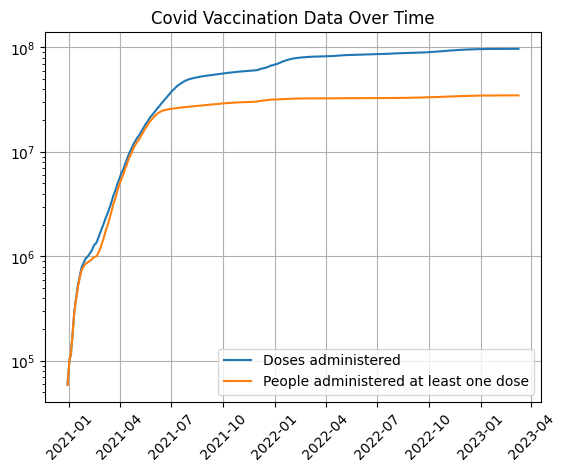

In [43]:
# 2.4/2.5 Getting Canada subset, plotting

covid_can_df = covid_df[covid_df['Country_Region']=='Canada']
covid_can_df['Date'] = pd.to_datetime(covid_can_df['Date'])

plt.plot(covid_can_df['Date'], covid_can_df['Doses_admin'], label='Doses administered')
plt.plot(covid_can_df['Date'], covid_can_df['People_at_least_one_dose'], label='People administered at least one dose')
plt.title('Covid Vaccination Data Over Time')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid()
plt.legend()

TODO clean this up prbly

This plot indicates that there was a sharp increase in covid vaccinations beginning January 2021, which corresponds to the time vaccines started becoming available to the general public. The number of people who had been administered one dose begins to level off just before July 2021. However, the number of doses administered still increases. This is likely because at that point, all the people who had already been vaccinated would continue to get boosters as recommended by the government guidelines.

In [45]:
# import required libraries

app_ui = ui.page_fluid(
    ui.input_date_range(
        "daterange", 
        "Date range", 
        start="2020-12-29", 
        end= '2023-03-09'
        ),  
    ui.output_plot('myplot'),
)

def server(input, output, session):
    @output
    @render.plot
    def myplot():
        
        # Read the data
        # select the data for Canada
        url = 'https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/global_data/time_series_covid19_vaccine_global.csv'
        covid_df = pd.read_csv(url)

        covid_can_df = covid_df[covid_df['Country_Region']=='Canada']
        covid_can_df['Date'] = pd.to_datetime(covid_can_df['Date'])


        # If you call the data frame as `df`, then the 
        # following codes select the rows in the user 
        # selected date range
        covid_can_df = covid_can_df[covid_can_df['Date'] > pd.Timestamp(input.daterange()[0])]
        covid_can_df = covid_can_df[covid_can_df['Date'] < pd.Timestamp(input.daterange()[1])]
        
        # Create the plot using `df`
        plt.plot(covid_can_df['Date'], covid_can_df['Doses_admin'], label='Doses administered')
        plt.plot(covid_can_df['Date'], covid_can_df['People_at_least_one_dose'], label='People administered at least one dose')
        plt.title('Covid Vaccination Data Over Time')
        plt.yscale('log')
        plt.xticks(rotation=45)
        plt.grid()
        plt.legend() 

app = App(app_ui, server)

Link to deployed app: https://melina-ash.shinyapps.io/asgn_2_shiny/